In [1]:
!pip install transformers torch datasets requests accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
import requests
import xml.etree.ElementTree as ET
import time
import pickle
from google.colab import drive
import os

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
model = AutoModel.from_pretrained("Qwen/Qwen2.5-3B-Instruct")

def get_embeddings(texts, pooling='mean'):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling over sequence length
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
print(f"Model loaded: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

Model loaded: 3085.9M parameters


In [6]:
# Cell 3: Fetch AI abstracts
def fetch_ai_abstracts(max_results=10000):
    abstracts = []
    batch_size = 100

    # Multiple AI-related categories
    categories = [
        "cs.AI",     # Artificial Intelligence
        "cs.LG",     # Machine Learning
        "cs.CL",     # Computation and Language (NLP)
        "cs.CV",     # Computer Vision and Pattern Recognition
        "cs.NE",     # Neural and Evolutionary Computing
        "cs.RO",     # Robotics
        "stat.ML"    # Machine Learning (Statistics)
    ]

    # Date range: January 2025 to August 2025
    date_query = "submittedDate:[20250101* TO 20250831*]"

    # Combine categories with OR operator
    category_query = " OR ".join([f"cat:{cat}" for cat in categories])

    # Full query combining categories and date range
    query = f"({category_query}) AND {date_query}"

    print(f"Fetching {max_results} AI abstracts from Jan 2025 - Aug 2025...")
    print(f"Categories: {', '.join(categories)}")

    for i in range(0, max_results, batch_size):
        current_batch = min(batch_size, max_results - i)
        # URL encode the query
        import urllib.parse
        encoded_query = urllib.parse.quote(query)
        url = f"http://export.arxiv.org/api/query?search_query={encoded_query}&start={i}&max_results={current_batch}&sortBy=submittedDate&sortOrder=descending"

        try:
            response = requests.get(url)
            root = ET.fromstring(response.content)

            for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
                # Get submission date to verify it's in our range
                published = entry.find('{http://www.w3.org/2005/Atom}published')
                if published is not None:
                    pub_date = published.text[:10]  # Extract YYYY-MM-DD
                    if pub_date >= "2025-01-01" and pub_date <= "2025-08-31":
                        summary = entry.find('{http://www.w3.org/2005/Atom}summary')
                        if summary is not None:
                            abstract = summary.text.strip().replace('\n', ' ')
                            abstracts.append(abstract)

            print(f"Fetched {len(abstracts)} abstracts...")
            time.sleep(1)  # Be nice to arXiv API

        except Exception as e:
            print(f"Error: {e}")
            continue

    print(f"Total: {len(abstracts)} abstracts from Jan-Aug 2025")
    return abstracts

In [7]:
# Mount Google Drive to save data persistently
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Fetch the abstracts
ai_abstracts = fetch_ai_abstracts(20000)

Fetching 20000 AI abstracts from Jan 2025 - Aug 2025...
Categories: cs.AI, cs.LG, cs.CL, cs.CV, cs.NE, cs.RO, stat.ML
Fetched 100 abstracts...
Fetched 200 abstracts...
Fetched 200 abstracts...
Fetched 200 abstracts...
Fetched 300 abstracts...
Fetched 400 abstracts...
Fetched 500 abstracts...
Fetched 600 abstracts...
Fetched 600 abstracts...
Fetched 700 abstracts...
Fetched 800 abstracts...
Fetched 900 abstracts...
Fetched 900 abstracts...
Fetched 1000 abstracts...
Fetched 1000 abstracts...
Fetched 1000 abstracts...
Fetched 1000 abstracts...
Fetched 1000 abstracts...
Fetched 1000 abstracts...
Fetched 1100 abstracts...
Fetched 1100 abstracts...
Fetched 1100 abstracts...
Fetched 1100 abstracts...
Fetched 1100 abstracts...
Fetched 1200 abstracts...
Fetched 1300 abstracts...
Fetched 1300 abstracts...
Fetched 1300 abstracts...
Fetched 1300 abstracts...
Fetched 1400 abstracts...
Fetched 1500 abstracts...
Fetched 1600 abstracts...
Fetched 1600 abstracts...
Fetched 1600 abstracts...
Fetched 160

In [9]:
# Create a directory for your project if it doesn't exist
project_dir = '/content/drive/My Drive/AI_Abstracts_Analysis'
os.makedirs(project_dir, exist_ok=True)

In [10]:
# Save the abstracts to Google Drive using pickle
abstracts_file = os.path.join(project_dir, 'ai_abstracts_2025_jan_aug.pkl')
with open(abstracts_file, 'wb') as f:
    pickle.dump(ai_abstracts, f)

print(f"Saved {len(ai_abstracts)} abstracts to: {abstracts_file}")

Saved 4800 abstracts to: /content/drive/My Drive/AI_Abstracts_Analysis/ai_abstracts_2025_jan_aug.pkl


In [11]:
# Also save as a text file for easy reading
text_file = os.path.join(project_dir, 'ai_abstracts_2025_jan_aug.txt')
with open(text_file, 'w', encoding='utf-8') as f:
    for i, abstract in enumerate(ai_abstracts, 1):
        f.write(f"Abstract {i}:\n{abstract}\n\n")

print(f"Also saved as text file: {text_file}")

Also saved as text file: /content/drive/My Drive/AI_Abstracts_Analysis/ai_abstracts_2025_jan_aug.txt


In [12]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
import gc

def convert_abstracts_to_embeddings(abstracts, model_name="Qwen/Qwen2.5-3B-Instruct", batch_size=16, max_length=512):
    """
    Convert abstracts to token embeddings using Qwen 2.5-3B

    Args:
        abstracts: List of abstract texts
        model_name: HuggingFace model name
        batch_size: Number of abstracts to process at once
        max_length: Maximum token length for each abstract

    Returns:
        numpy array of embeddings (n_abstracts, embedding_dim)
    """
    print(f"Loading {model_name}...")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16)

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    print(f"Using device: {device}")
    print(f"Processing {len(abstracts)} abstracts in batches of {batch_size}")

    all_embeddings = []

    # Process in batches
    for i in tqdm(range(0, len(abstracts), batch_size), desc="Converting to embeddings"):
        batch_texts = abstracts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use mean pooling over sequence dimension
            # Shape: (batch_size, seq_len, hidden_dim) -> (batch_size, hidden_dim)
            embeddings = outputs.last_hidden_state.mean(dim=1)

            # Move to CPU and convert to numpy
            embeddings = embeddings.cpu().numpy()
            all_embeddings.append(embeddings)

        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        # Clear variables
        del inputs, outputs, embeddings
        gc.collect()

    # Concatenate all embeddings
    final_embeddings = np.vstack(all_embeddings)

    print(f"Generated embeddings shape: {final_embeddings.shape}")
    return final_embeddings

# Convert your AI abstracts to embeddings
print("Converting 4700 AI abstracts to token embeddings...")
ai_embeddings_2025 = convert_abstracts_to_embeddings(
    ai_abstracts,
    batch_size=16,  # Adjust based on your GPU memory
    max_length=512  # Most abstracts should fit in 512 tokens
)

# Save embeddings for later use
np.save('ai_abstracts_2025_embeddings.npy', ai_embeddings_2025)
print(f"Saved embeddings to 'ai_abstracts_2025_embeddings.npy'")

# Print some basic statistics
print(f"\nEmbedding Statistics:")
print(f"Shape: {ai_embeddings_2025.shape}")
print(f"Mean: {ai_embeddings_2025.mean():.4f}")
print(f"Std: {ai_embeddings_2025.std():.4f}")
print(f"Min: {ai_embeddings_2025.min():.4f}")
print(f"Max: {ai_embeddings_2025.max():.4f}")

Converting 4700 AI abstracts to token embeddings...
Loading Qwen/Qwen2.5-3B-Instruct...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using device: cuda
Processing 4800 abstracts in batches of 16


Converting to embeddings: 100%|██████████| 300/300 [02:50<00:00,  1.76it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Generated embeddings shape: (4800, 2048)
Saved embeddings to 'ai_abstracts_2025_embeddings.npy'

Embedding Statistics:
Shape: (4800, 2048)
Mean: -0.0234
Std: inf
Min: -88.3125
Max: 69.4375


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import normalize
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [17]:
def diagnose_embeddings(embeddings, name="Embeddings"):
    """
    Diagnose potential issues with embeddings
    """
    print(f"\n{name} Diagnostics:")
    print(f"Shape: {embeddings.shape}")
    print(f"Mean: {np.mean(embeddings):.6f}")
    print(f"Std: {np.std(embeddings):.6f}")
    print(f"Min: {np.min(embeddings):.6f}")
    print(f"Max: {np.max(embeddings):.6f}")

    # Check for extreme values
    extreme_count = np.sum((embeddings < -10) | (embeddings > 10))
    print(f"Values outside [-10, 10]: {extreme_count} ({extreme_count/embeddings.size*100:.2f}%)")

    # Check for infinite or NaN values
    inf_count = np.sum(np.isinf(embeddings))
    nan_count = np.sum(np.isnan(embeddings))
    print(f"Infinite values: {inf_count}")
    print(f"NaN values: {nan_count}")

    # Check distribution of norms
    norms = np.linalg.norm(embeddings, axis=1)
    print(f"Norm statistics - Mean: {np.mean(norms):.4f}, Std: {np.std(norms):.4f}")
    print(f"Norm range: [{np.min(norms):.4f}, {np.max(norms):.4f}]")

    return {
        'has_extremes': extreme_count > 0,
        'has_inf': inf_count > 0,
        'has_nan': nan_count > 0,
        'extreme_count': extreme_count,
        'norm_stats': {'mean': np.mean(norms), 'std': np.std(norms)}
    }


In [18]:
def load_base_model_embeddings(model_path_or_model):
    """
    Load base model token embeddings

    Args:
        model_path_or_model: Either path to model or loaded model object

    Returns:
        numpy array of base model token embeddings
    """
    if isinstance(model_path_or_model, str):
        # Load model if path is provided
        from transformers import AutoModel
        model = AutoModel.from_pretrained(model_path_or_model)
        base_embeddings = model.embed_tokens.weight.detach().numpy()
    else:
        # Use already loaded model
        base_embeddings = model_path_or_model.embed_tokens.weight.detach().numpy()

    print(f"Base model embeddings shape: {base_embeddings.shape}")
    return base_embeddings

In [20]:
def compare_base_vs_new_embeddings(base_embeddings, new_embeddings, sample_size=5000):
    """
    Compare base model embeddings vs new data embeddings

    Args:
        base_embeddings: Token embeddings from base model (vocab_size, embedding_dim)
        new_embeddings: Embeddings from new data (n_samples, embedding_dim)
        sample_size: Number of base embeddings to sample for comparison
    """
    print(f"Base embeddings shape: {base_embeddings.shape}")
    print(f"New embeddings shape: {new_embeddings.shape}")

    # Sample from base embeddings to make comparison manageable
    np.random.seed(42)
    sample_indices = np.random.choice(base_embeddings.shape[0],
                                    size=min(sample_size, base_embeddings.shape[0]),
                                    replace=False)
    base_sample = base_embeddings[sample_indices]

    print(f"Using {len(base_sample)} sampled base embeddings for comparison")

    # Ensure same embedding dimension
    min_dim = min(base_sample.shape[1], new_embeddings.shape[1])
    base_sample = base_sample[:, :min_dim]
    new_embeddings = new_embeddings[:, :min_dim]

    # Calculate distribution shift metrics
    results = {}

    # 1. Wasserstein distances
    print("Calculating Wasserstein distances...")
    wasserstein_distances = []
    for dim in range(min_dim):
        wd = wasserstein_distance(base_sample[:, dim], new_embeddings[:, dim])
        wasserstein_distances.append(wd)

    results['wasserstein_per_dim'] = np.array(wasserstein_distances)
    results['avg_wasserstein'] = np.mean(wasserstein_distances)
    results['max_wasserstein'] = np.max(wasserstein_distances)
    results['std_wasserstein'] = np.std(wasserstein_distances)

    # 2. Jensen-Shannon divergences
    print("Calculating Jensen-Shannon divergences...")
    js_distances = []

    # Check for any extreme values first
    print(f"Base sample - Min: {np.min(base_sample):.4f}, Max: {np.max(base_sample):.4f}")
    print(f"New embeddings - Min: {np.min(new_embeddings):.4f}, Max: {np.max(new_embeddings):.4f}")

    # Clip extreme values to prevent overflow
    base_clipped = np.clip(base_sample, -10, 10)
    new_clipped = np.clip(new_embeddings, -10, 10)

    for dim in range(min_dim):
        try:
            # Use clipped values and more robust binning
            base_vals = base_clipped[:, dim]
            new_vals = new_clipped[:, dim]

            # Create common bins based on the range of both datasets
            min_val = min(np.min(base_vals), np.min(new_vals))
            max_val = max(np.max(base_vals), np.max(new_vals))
            bins = np.linspace(min_val, max_val, 51)

            # Create histograms
            hist1, _ = np.histogram(base_vals, bins=bins, density=True)
            hist2, _ = np.histogram(new_vals, bins=bins, density=True)

            # Convert to probabilities and add small epsilon
            hist1 = hist1 / (np.sum(hist1) + 1e-15) + 1e-15
            hist2 = hist2 / (np.sum(hist2) + 1e-15) + 1e-15

            # Ensure they sum to 1
            hist1 = hist1 / np.sum(hist1)
            hist2 = hist2 / np.sum(hist2)

            js_dist = jensenshannon(hist1, hist2)

            # Check for valid result
            if np.isfinite(js_dist):
                js_distances.append(js_dist)
            else:
                js_distances.append(0.0)  # Default to 0 if calculation fails

        except Exception as e:
            print(f"Error calculating JS divergence for dimension {dim}: {e}")
            js_distances.append(0.0)

    results['js_per_dim'] = np.array(js_distances)
    results['avg_js'] = np.nanmean(js_distances)  # Use nanmean to handle any remaining NaNs
    results['max_js'] = np.nanmax(js_distances)
    results['std_js'] = np.nanstd(js_distances)

    # 3. Statistical summaries with robust calculations
    results['base_mean'] = np.mean(base_clipped)
    results['new_mean'] = np.mean(new_clipped)
    results['base_std'] = np.std(base_clipped)
    results['new_std'] = np.std(new_clipped)

    # Additional diagnostics
    results['base_has_extreme'] = np.any((base_sample < -10) | (base_sample > 10))
    results['new_has_extreme'] = np.any((new_embeddings < -10) | (new_embeddings > 10))
    results['base_extreme_count'] = np.sum((base_sample < -10) | (base_sample > 10))
    results['new_extreme_count'] = np.sum((new_embeddings < -10) | (new_embeddings > 10))

    return results, base_sample

In [21]:
def visualize_base_vs_new(base_sample, new_embeddings, save_prefix='base_vs_new'):
    """
    Create comprehensive visualizations comparing base model vs new data embeddings
    """
    # Combine embeddings
    combined_embeddings = np.vstack([base_sample, new_embeddings])
    combined_labels = np.array(['Base Model'] * len(base_sample) +
                              ['2025 AI Data'] * len(new_embeddings))

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. PCA visualization
    print("Computing PCA...")
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(combined_embeddings)

    ax1 = axes[0, 0]
    colors = ['blue', 'red']
    for i, label in enumerate(['Base Model', '2025 AI Data']):
        mask = combined_labels == label
        ax1.scatter(pca_embeddings[mask, 0], pca_embeddings[mask, 1],
                   alpha=0.6, label=label, s=20, c=colors[i])
    ax1.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. UMAP visualization
    print("Computing UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    umap_embeddings = reducer.fit_transform(combined_embeddings)

    ax2 = axes[0, 1]
    for i, label in enumerate(['Base Model', '2025 AI Data']):
        mask = combined_labels == label
        ax2.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],
                   alpha=0.6, label=label, s=20, c=colors[i])
    ax2.set_title('UMAP Projection')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. First principal component distributions
    ax3 = axes[0, 2]
    pca_base = pca.transform(base_sample)
    pca_new = pca.transform(new_embeddings)

    ax3.hist(pca_base[:, 0], alpha=0.6, bins=50, label='Base Model PC1', density=True, color='blue')
    ax3.hist(pca_new[:, 0], alpha=0.6, bins=50, label='2025 AI Data PC1', density=True, color='red')
    ax3.set_title('Distribution of First Principal Component')
    ax3.set_xlabel('PC1 Value')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Embedding norms comparison
    ax4 = axes[1, 0]
    base_norms = np.linalg.norm(base_sample, axis=1)
    new_norms = np.linalg.norm(new_embeddings, axis=1)

    ax4.hist(base_norms, alpha=0.6, bins=50, label='Base Model', density=True, color='blue')
    ax4.hist(new_norms, alpha=0.6, bins=50, label='2025 AI Data', density=True, color='red')
    ax4.set_title('Distribution of Embedding Norms')
    ax4.set_xlabel('L2 Norm')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Mean values per dimension (first 100 dims)
    ax5 = axes[1, 1]
    dims_to_show = min(100, base_sample.shape[1])
    base_means = np.mean(base_sample[:, :dims_to_show], axis=0)
    new_means = np.mean(new_embeddings[:, :dims_to_show], axis=0)

    ax5.plot(base_means, label='Base Model', alpha=0.7, color='blue')
    ax5.plot(new_means, label='2025 AI Data', alpha=0.7, color='red')
    ax5.set_title(f'Mean Values per Dimension (first {dims_to_show} dims)')
    ax5.set_xlabel('Dimension')
    ax5.set_ylabel('Mean Value')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Standard deviation per dimension
    ax6 = axes[1, 2]
    base_stds = np.std(base_sample[:, :dims_to_show], axis=0)
    new_stds = np.std(new_embeddings[:, :dims_to_show], axis=0)

    ax6.plot(base_stds, label='Base Model', alpha=0.7, color='blue')
    ax6.plot(new_stds, label='2025 AI Data', alpha=0.7, color='red')
    ax6.set_title(f'Standard Deviation per Dimension (first {dims_to_show} dims)')
    ax6.set_xlabel('Dimension')
    ax6.set_ylabel('Standard Deviation')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{save_prefix}_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


In [22]:
# Load your base model (replace with your actual model loading)
#from transformers import AutoModel
#model = AutoModel.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
base_embeddings = model.embed_tokens.weight.detach().numpy()

# Load your 2025 AI embeddings
ai_embeddings_2025 = np.load('ai_abstracts_2025_embeddings.npy')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Base Model Embeddings Diagnostics:
Shape: (151936, 2048)
Mean: -0.000096
Std: 0.024321
Min: -0.243164
Max: 0.233398
Values outside [-10, 10]: 0 (0.00%)
Infinite values: 0
NaN values: 0
Norm statistics - Mean: 1.0890, Std: 0.1599
Norm range: [0.3796, 1.6249]

2025 AI Embeddings Diagnostics:
Shape: (4800, 2048)
Mean: -0.023376


/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Std: inf
Min: -88.312500
Max: 69.437500
Values outside [-10, 10]: 107185 (1.09%)
Infinite values: 0
NaN values: 0
Norm statistics - Mean: 138.8750, Std: inf
Norm range: [83.8750, 175.5000]
Base embeddings shape: (151936, 2048)
New embeddings shape: (4800, 2048)
Using 5000 sampled base embeddings for comparison
Calculating Wasserstein distances...
Calculating Jensen-Shannon divergences...
Base sample - Min: -0.1885, Max: 0.1836
New embeddings - Min: -88.3125, Max: 69.4375
\nDistribution Shift Analysis Results:
Average Wasserstein Distance: 1.0029
Max Wasserstein Distance: 63.1381
Average Jensen-Shannon Divergence: 0.7468
Max Jensen-Shannon Divergence: 0.8326
Base Model Mean: -0.0001
New Data Mean: -0.0091
Base Model Std: 0.0244
New Data Std: inf
\nExtreme value handling:
Base extreme values: 0
New extreme values: 107185
Computing PCA...
Computing UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


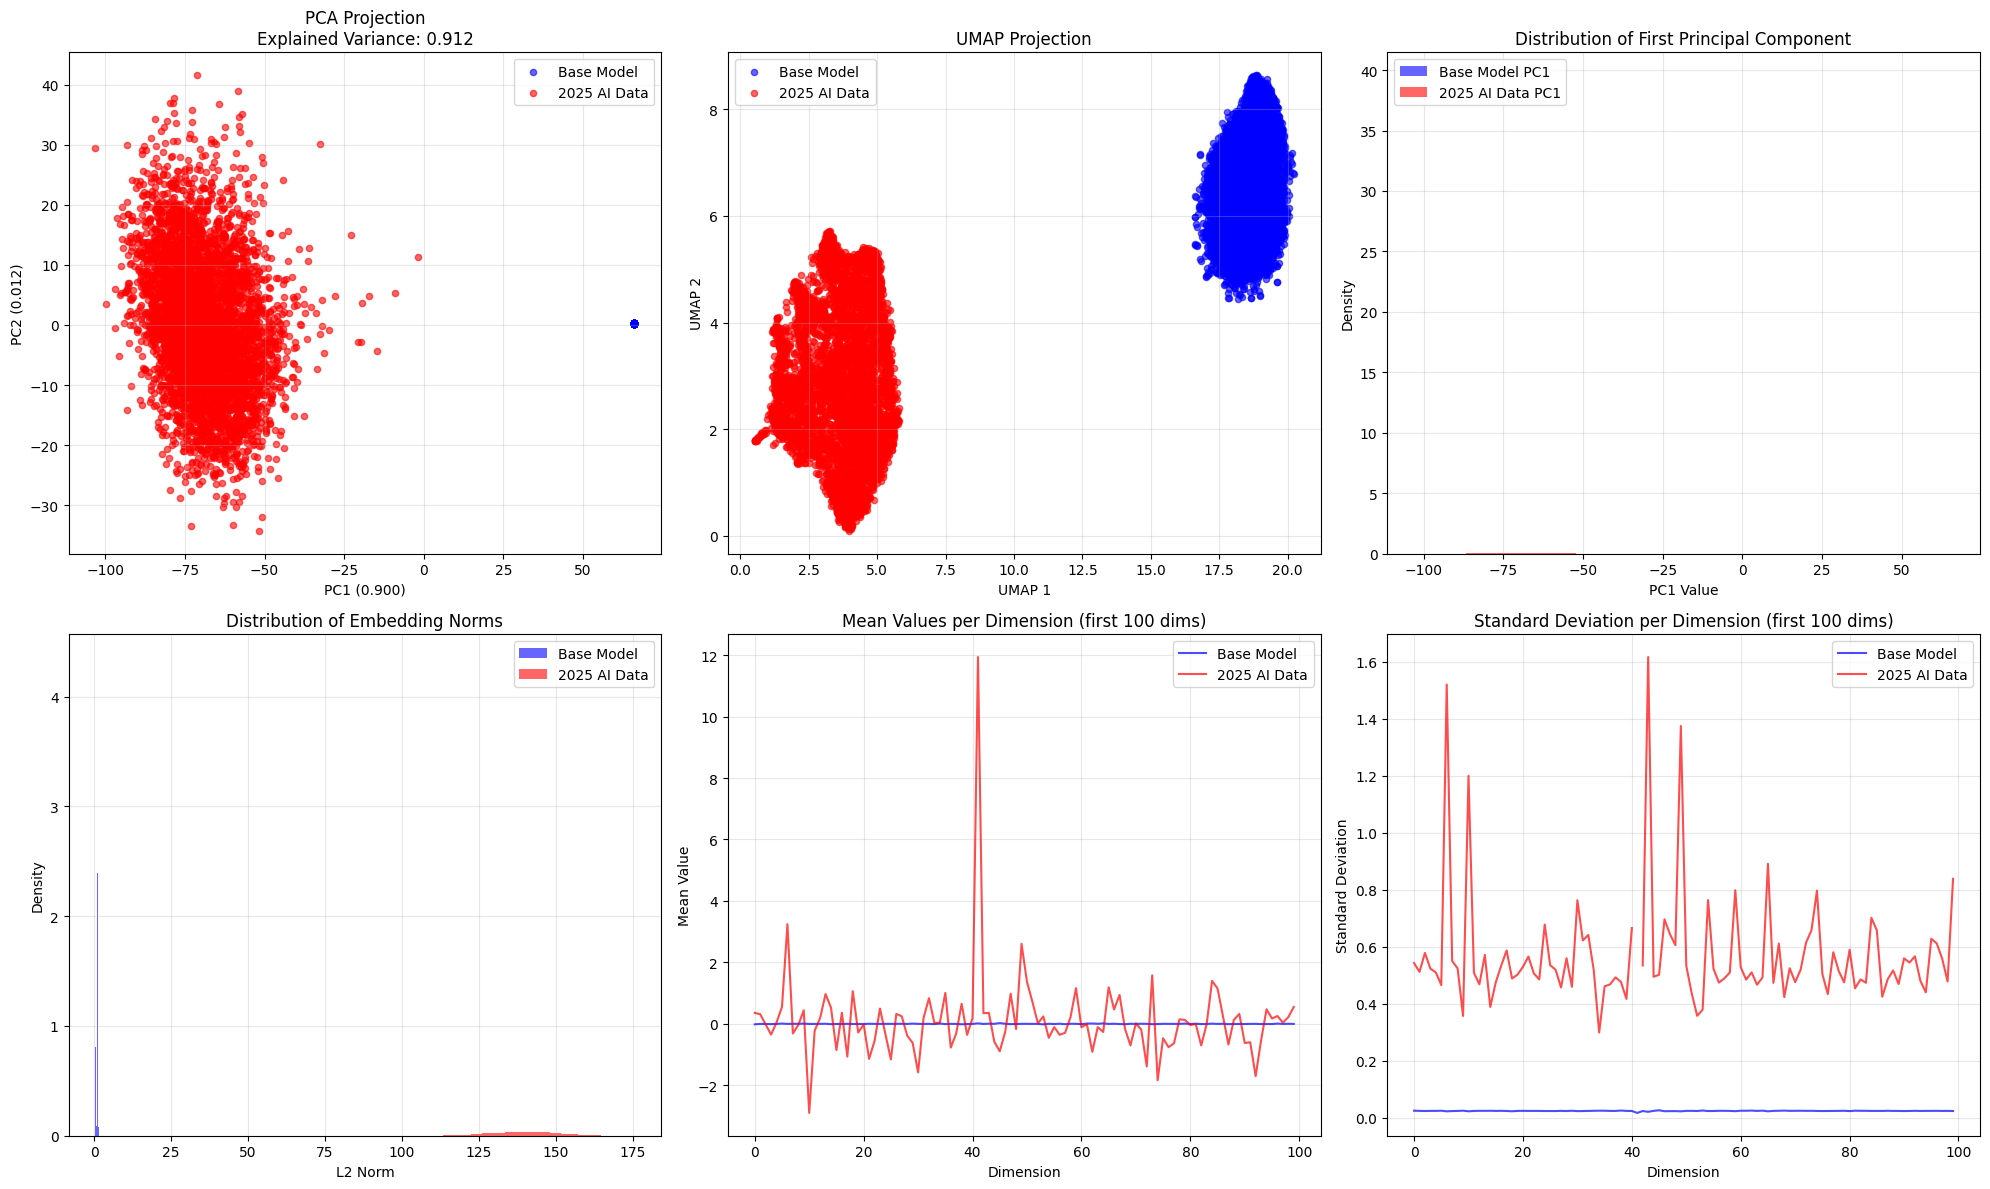

In [23]:
# Load your base model (replace with your actual model loading)
from transformers import AutoModel
base_model = AutoModel.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
base_embeddings = base_model.embed_tokens.weight.detach().numpy()

# Load your 2025 AI embeddings
ai_embeddings_2025 = np.load('ai_abstracts_2025_embeddings.npy')

# First, diagnose both embedding sets
base_diag = diagnose_embeddings(base_embeddings, "Base Model Embeddings")
new_diag = diagnose_embeddings(ai_embeddings_2025, "2025 AI Embeddings")

# Perform comparison
results, base_sample = compare_base_vs_new_embeddings(base_embeddings, ai_embeddings_2025)

# Print results
print("\\nDistribution Shift Analysis Results:")
print("="*50)
print(f"Average Wasserstein Distance: {results['avg_wasserstein']:.4f}")
print(f"Max Wasserstein Distance: {results['max_wasserstein']:.4f}")
print(f"Average Jensen-Shannon Divergence: {results['avg_js']:.4f}")
print(f"Max Jensen-Shannon Divergence: {results['max_js']:.4f}")
print(f"Base Model Mean: {results['base_mean']:.4f}")
print(f"New Data Mean: {results['new_mean']:.4f}")
print(f"Base Model Std: {results['base_std']:.4f}")
print(f"New Data Std: {results['new_std']:.4f}")

if results['base_has_extreme'] or results['new_has_extreme']:
    print(f"\\nExtreme value handling:")
    print(f"Base extreme values: {results['base_extreme_count']}")
    print(f"New extreme values: {results['new_extreme_count']}")

# Create visualizations
visualize_base_vs_new(base_sample, ai_embeddings_2025)

In [24]:
import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def detect_distribution_shift(base_embeddings, new_embeddings,
                            significance_level=0.05,
                            sample_size=5000,
                            verbose=True):
    """
    Detect distribution shift between two embedding sets using multiple statistical tests

    Args:
        base_embeddings: Base model embeddings (n_base, embedding_dim)
        new_embeddings: New data embeddings (n_new, embedding_dim)
        significance_level: P-value threshold for statistical significance
        sample_size: Number of samples to use for computation
        verbose: Whether to print detailed results

    Returns:
        dict: Results with binary shift detection and evidence metrics
    """

    if verbose:
        print("🔍 DISTRIBUTION SHIFT DETECTION")
        print("=" * 50)

    # Sample data for manageable computation
    np.random.seed(42)

    if len(base_embeddings) > sample_size:
        base_idx = np.random.choice(len(base_embeddings), sample_size, replace=False)
        base_sample = base_embeddings[base_idx]
    else:
        base_sample = base_embeddings.copy()

    if len(new_embeddings) > sample_size:
        new_idx = np.random.choice(len(new_embeddings), sample_size, replace=False)
        new_sample = new_embeddings[new_idx]
    else:
        new_sample = new_embeddings.copy()

    # Ensure same dimensions
    min_dim = min(base_sample.shape[1], new_sample.shape[1])
    base_sample = base_sample[:, :min_dim]
    new_sample = new_sample[:, :min_dim]

    if verbose:
        print(f"Comparing {len(base_sample)} base vs {len(new_sample)} new samples")
        print(f"Embedding dimension: {min_dim}")
        print()

    results = {
        'shift_detected': False,
        'confidence': 'Low',
        'evidence_score': 0,
        'max_evidence_score': 0,
        'tests': {}
    }

    # Test 1: Extreme Value Test (Quick Check)
    if verbose:
        print("Test 1: Extreme Value Analysis")

    base_extreme_pct = np.sum((np.abs(base_sample) > 10)) / base_sample.size * 100
    new_extreme_pct = np.sum((np.abs(new_sample) > 10)) / new_sample.size * 100

    extreme_difference = abs(new_extreme_pct - base_extreme_pct)

    results['tests']['extreme_values'] = {
        'base_extreme_pct': base_extreme_pct,
        'new_extreme_pct': new_extreme_pct,
        'difference': extreme_difference,
        'significant': extreme_difference > 0.1  # More than 0.1% difference
    }

    if verbose:
        print(f"  Base extreme values: {base_extreme_pct:.2f}%")
        print(f"  New extreme values: {new_extreme_pct:.2f}%")
        print(f"  Difference: {extreme_difference:.2f}%")

    if extreme_difference > 0.1:
        results['evidence_score'] += 2
        if verbose:
            print("  ✅ STRONG EVIDENCE: Significant difference in extreme values")
    else:
        if verbose:
            print("  ❌ No significant extreme value difference")

    results['max_evidence_score'] += 2
    if verbose:
        print()

    # Test 2: Distribution Scale Test (Norms)
    if verbose:
        print("Test 2: Embedding Scale Analysis")

    # Use clipped values for norm calculation to avoid infinity
    base_clipped = np.clip(base_sample, -50, 50)
    new_clipped = np.clip(new_sample, -50, 50)

    base_norms = np.linalg.norm(base_clipped, axis=1)
    new_norms = np.linalg.norm(new_clipped, axis=1)

    # Welch's t-test (doesn't assume equal variances)
    try:
        t_stat, t_pval = stats.ttest_ind(base_norms, new_norms, equal_var=False)
        norm_test_valid = not (np.isnan(t_pval) or np.isinf(t_pval))
    except:
        t_stat, t_pval = np.nan, 1.0
        norm_test_valid = False

    norm_ratio = np.mean(new_norms) / np.mean(base_norms) if np.mean(base_norms) > 0 else np.inf

    results['tests']['norm_shift'] = {
        'base_norm_mean': np.mean(base_norms),
        'new_norm_mean': np.mean(new_norms),
        'norm_ratio': norm_ratio,
        't_pvalue': t_pval,
        'significant': norm_test_valid and t_pval < significance_level
    }

    if verbose:
        print(f"  Base norm mean: {np.mean(base_norms):.4f}")
        print(f"  New norm mean: {np.mean(new_norms):.4f}")
        print(f"  Norm ratio: {norm_ratio:.2f}")
        if norm_test_valid:
            print(f"  T-test p-value: {t_pval:.6f}")

    if norm_test_valid and t_pval < significance_level:
        results['evidence_score'] += 2
        if verbose:
            print("  ✅ STRONG EVIDENCE: Significant difference in embedding scales")
    elif norm_ratio > 2.0 or norm_ratio < 0.5:
        results['evidence_score'] += 1
        if verbose:
            print("  ⚠️  MODERATE EVIDENCE: Large difference in embedding scales")
    else:
        if verbose:
            print("  ❌ No significant scale difference")

    results['max_evidence_score'] += 2
    if verbose:
        print()

    # Test 3: Wasserstein Distance Test
    if verbose:
        print("Test 3: Wasserstein Distance Analysis")

    # Test on first 20 dimensions for speed
    test_dims = min(20, min_dim)
    wasserstein_distances = []

    for dim in range(test_dims):
        wd = wasserstein_distance(base_clipped[:, dim], new_clipped[:, dim])
        if np.isfinite(wd):
            wasserstein_distances.append(wd)

    if wasserstein_distances:
        avg_wasserstein = np.mean(wasserstein_distances)
        max_wasserstein = np.max(wasserstein_distances)
    else:
        avg_wasserstein = 0
        max_wasserstein = 0

    results['tests']['wasserstein'] = {
        'average_distance': avg_wasserstein,
        'max_distance': max_wasserstein,
        'dimensions_tested': len(wasserstein_distances),
        'significant': avg_wasserstein > 0.5  # Threshold for meaningful shift
    }

    if verbose:
        print(f"  Average Wasserstein distance: {avg_wasserstein:.4f}")
        print(f"  Maximum Wasserstein distance: {max_wasserstein:.4f}")
        print(f"  Dimensions tested: {len(wasserstein_distances)}")

    if avg_wasserstein > 1.0:
        results['evidence_score'] += 2
        if verbose:
            print("  ✅ STRONG EVIDENCE: High Wasserstein distance")
    elif avg_wasserstein > 0.5:
        results['evidence_score'] += 1
        if verbose:
            print("  ⚠️  MODERATE EVIDENCE: Moderate Wasserstein distance")
    else:
        if verbose:
            print("  ❌ Low Wasserstein distance")

    results['max_evidence_score'] += 2
    if verbose:
        print()

    # Test 4: Principal Component Analysis
    if verbose:
        print("Test 4: Principal Component Shift Analysis")

    try:
        # Combine and compute PCA
        combined_data = np.vstack([base_clipped, new_clipped])
        pca = PCA(n_components=min(5, min_dim))
        pca.fit(combined_data)

        base_pca = pca.transform(base_clipped)
        new_pca = pca.transform(new_clipped)

        # KS test on first 3 principal components
        ks_pvalues = []
        for i in range(min(3, base_pca.shape[1])):
            ks_stat, ks_pval = stats.ks_2samp(base_pca[:, i], new_pca[:, i])
            if np.isfinite(ks_pval):
                ks_pvalues.append(ks_pval)

        significant_pcs = np.sum(np.array(ks_pvalues) < significance_level) if ks_pvalues else 0
        min_pvalue = np.min(ks_pvalues) if ks_pvalues else 1.0

        results['tests']['pca_shift'] = {
            'significant_components': significant_pcs,
            'total_components': len(ks_pvalues),
            'min_pvalue': min_pvalue,
            'explained_variance': pca.explained_variance_ratio_[:3].tolist()
        }

        if verbose:
            print(f"  Significant PC shifts: {significant_pcs}/{len(ks_pvalues)}")
            print(f"  Minimum p-value: {min_pvalue:.6f}")
            print(f"  Explained variance (first 3 PCs): {pca.explained_variance_ratio_[:3]}")

        if significant_pcs >= 2:
            results['evidence_score'] += 2
            if verbose:
                print("  ✅ STRONG EVIDENCE: Multiple principal components shifted")
        elif significant_pcs >= 1:
            results['evidence_score'] += 1
            if verbose:
                print("  ⚠️  MODERATE EVIDENCE: Some principal components shifted")
        else:
            if verbose:
                print("  ❌ No significant PC shifts detected")

    except Exception as e:
        if verbose:
            print(f"  ❌ PCA analysis failed: {str(e)}")
        results['tests']['pca_shift'] = {'error': str(e)}

    results['max_evidence_score'] += 2
    if verbose:
        print()

    # Final Decision
    evidence_ratio = results['evidence_score'] / results['max_evidence_score']

    if evidence_ratio >= 0.75:
        results['shift_detected'] = True
        results['confidence'] = 'High'
    elif evidence_ratio >= 0.5:
        results['shift_detected'] = True
        results['confidence'] = 'Moderate'
    elif evidence_ratio >= 0.25:
        results['shift_detected'] = True
        results['confidence'] = 'Low'
    else:
        results['shift_detected'] = False
        results['confidence'] = 'None'

    if verbose:
        print("🎯 FINAL RESULT")
        print("=" * 30)
        print(f"Evidence Score: {results['evidence_score']}/{results['max_evidence_score']} ({evidence_ratio:.1%})")
        print(f"Distribution Shift: {'✅ DETECTED' if results['shift_detected'] else '❌ NOT DETECTED'}")
        print(f"Confidence Level: {results['confidence']}")

        if results['shift_detected']:
            print("\n📊 CONCLUSION: Significant distribution shift detected between base model")
            print("   embeddings and 2025 AI data embeddings. This supports your hypothesis")
            print("   that the new data represents an out-of-domain shift.")
        else:
            print("\n📊 CONCLUSION: No significant distribution shift detected. The new data")
            print("   appears to be from a similar distribution as the base model.")

        print("=" * 50)

    return results

# Quick usage function
def quick_shift_check(base_embeddings, new_embeddings):
    """Quick yes/no check for distribution shift"""
    result = detect_distribution_shift(base_embeddings, new_embeddings, verbose=False)
    return result['shift_detected'], result['confidence']

In [25]:
# Detect shift
shift_results = detect_distribution_shift(base_embeddings, ai_embeddings_2025)

# Quick check
shift_detected, confidence = quick_shift_check(base_embeddings, ai_embeddings_2025)
print(f"Shift detected: {shift_detected} (confidence: {confidence})")

# For your paper, report:
print(f"Distribution shift: {shift_results['shift_detected']}")
print(f"Evidence score: {shift_results['evidence_score']}/{shift_results['max_evidence_score']}")
print(f"Key metrics:")
print(f"- Wasserstein distance: {shift_results['tests']['wasserstein']['average_distance']:.4f}")
print(f"- Norm ratio: {shift_results['tests']['norm_shift']['norm_ratio']:.2f}")

🔍 DISTRIBUTION SHIFT DETECTION
Comparing 5000 base vs 4800 new samples
Embedding dimension: 2048

Test 1: Extreme Value Analysis
  Base extreme values: 0.00%
  New extreme values: 1.09%
  Difference: 1.09%
  ✅ STRONG EVIDENCE: Significant difference in extreme values

Test 2: Embedding Scale Analysis
  Base norm mean: 1.0915
  New norm mean: 130.8750
  Norm ratio: 119.90
  T-test p-value: 0.000000
  ✅ STRONG EVIDENCE: Significant difference in embedding scales

Test 3: Wasserstein Distance Analysis
  Average Wasserstein distance: 0.8498
  Maximum Wasserstein distance: 3.2627
  Dimensions tested: 20
  ⚠️  MODERATE EVIDENCE: Moderate Wasserstein distance

Test 4: Principal Component Shift Analysis
  Significant PC shifts: 3/3
  Minimum p-value: 0.000000
  Explained variance (first 3 PCs): [0.8941471  0.01073035 0.00842523]
  ✅ STRONG EVIDENCE: Multiple principal components shifted

🎯 FINAL RESULT
Evidence Score: 7/8 (87.5%)
Distribution Shift: ✅ DETECTED
Confidence Level: High

📊 CONCLUS